# Fitting XGBoost Classifier for Production

In [4]:
import os

# set dir by hardcode to run in crontab
os.chdir("/home/jacob/Project/LendingClub/")

import Data_Helper as DH
import lendingclub
import prediction
import numpy as np
import pandas as pd
import json
import time
import sklearn
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None  # default='warn'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## a. Instantiate Objects

In [5]:
# initialize config object
config = lendingclub.ConfigData("config_data.ini")

# initialize lendingclup api object
lc = lendingclub.LendingClub(config)

# initialize data transformer
transformer = DH.Transformer_full()

# initialize DataHelper
periodStart = ("Q1", "2016")
periodEnd = ("Q1", "2018")
DataHelper = DH.DataHelper(periodStart, periodEnd, transformer, lc)

In [3]:
# set training data
DataHelper.set_training_dataset()

In [4]:
# set test data
DataHelper.set_test_dataset(["LoanStats_2018Q2.csv", "LoanStats_2018Q3.csv"])

## b. Check GPU works

In [5]:
# instantiate our model
xgb = prediction.ModelXGBClassfication()

In [6]:
# get training/test for this model
training, test = xgb.get_data_for_model(DataHelper.training, DataHelper.test)

In [7]:
param = {
    "n_estimators": 500,
    "tree_method": 'auto',
    "learning_rate": 0.01,
    "max_depth": 6, 
    "min_child_weight": 1,
    "gamma": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0
}

In [8]:
# Check time - auto
start = time.time()
model1 = xgb.fit_model(training, **param)
end = time.time()
print("auto: ", end - start)

auto:  476.1655135154724


In [9]:
param["tree_method"]= 'hist'

# Check time - auto
start = time.time()
model2 = xgb.fit_model(training, **param)
end = time.time()
print("hist: ", end - start)

hist:  103.32571005821228


In [10]:
param["tree_method"]= 'gpu_hist'

# Check time - auto
start = time.time()
model3 = xgb.fit_model(training, **param)
end = time.time()
print("gpu_hist: ", end - start)

gpu_hist:  68.54222989082336


## c. FItting

### Quick train for n_estimators

In [8]:
# instantiate our model
xgb = prediction.ModelXGBClassfication()

In [9]:
# get training/test for this model
training, test = xgb.get_data_for_model(DataHelper.training, DataHelper.test)

In [7]:
# tree_method - gpu_hist
param = {
    "n_estimators": 5000,
    "tree_method": 'hist',
    "learning_rate": 0.01,
    "max_depth": 6, 
    "min_child_weight": 1,
    "gamma": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0,
}

In [8]:
# Check time - auto
start = time.time()
print("tree_method: hist")
param["n_estimators"] = xgb.fit_n_estimator(training, 5, 50, **param)
end = time.time()
print("hist: ", end - start)

tree_method: hist
stop at 3922 test-mean-auc: 0.7112, test-std-auc: 0.0019
hist:  3557.7172508239746


In [7]:
# tree_method - gpu_hist
param = {
    "n_estimators": 5000,
    "tree_method": 'auto',
    "learning_rate": 0.01,
    "max_depth": 6, 
    "min_child_weight": 1,
    "gamma": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0,
}

In [8]:
# Check time - auto
start = time.time()
print("tree_method: auto")
param["n_estimators"] = xgb.fit_n_estimator(training, 5, 50, **param)
end = time.time()
print("auto: ", end - start)

tree_method: auto
stop at 3887 test-mean-auc: 0.7108, test-std-auc: 0.002
auto:  13126.523601531982


### max_depth and min_child_weight

In [10]:
# tree_method - gpu_hist
param = {
    "n_estimators": 3922,
    "tree_method": 'gpu_hist',
    "learning_rate": 0.01,
    "max_depth": 6, 
    "min_child_weight": 1,
    "gamma": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0,
}

shuffle = True

In [11]:
# get CVs
CVs = DataHelper.get_cross_validation_data(fold=5, shuffle=shuffle)

In [12]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["max_depth"] = list(range(3,10,2))
param_CV["min_child_weight"] = list(range(1,6,2))
grids = xgb.construct_grids(**param_CV)

In [13]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [14]:
# choose best Grid
scores, avg_score, param = xgb.best_grid(scores, "AUC")
print(avg_score)
print("max_depth: {}, min_child_weight: {}".format(param["max_depth"], param["min_child_weight"]))

0.712046053825987
max_depth: 7, min_child_weight: 5


Further tuning

In [16]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["max_depth"] = [6,7,8]
param_CV["min_child_weight"] = [4, 5]
grids = xgb.construct_grids(**param_CV)

In [17]:
# get CVs
CVs = DataHelper.get_cross_validation_data(fold=5, shuffle=shuffle)

In [18]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [19]:
# choose best Grid
scores, avg_score, param = xgb.best_grid(scores, "AUC")
print(avg_score)
print("max_depth: {}, min_child_weight: {}".format(param["max_depth"], param["min_child_weight"]))

0.7118246159112435
max_depth: 6, min_child_weight: 5


## Tune Gamma

In [23]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["gamma"] = [i/10.0 for i in range(0,5)]
grids = xgb.construct_grids(**param_CV)

In [24]:
# get CVs
CVs = DataHelper.get_cross_validation_data(fold=5, shuffle=shuffle)

In [25]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [26]:
# choose best Grid
scores, avg_score, param = xgb.best_grid(scores, "AUC")
print(avg_score)
print("gamma: {}".format(param["gamma"]))

0.7121560335277397
gamma: 0.2


### Tune subsample and colsample_bytree

In [30]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["subsample"] = [i/10 for i in range(3,9)]
param_CV["colsample_bytree"] = [i/10 for i in range(5,9)]
grids = xgb.construct_grids(**param_CV)

In [31]:
# get CVs
CVs = DataHelper.get_cross_validation_data(fold=5, shuffle=shuffle)

In [32]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [33]:
new_scores,avg_score, param = xgb.best_grid(scores, "AUC")
print(avg_score)
print("subsample: {}, colsample_bytree: {}".format(param["subsample"], param["colsample_bytree"]))

0.7121389738432969
subsample: 0.7, colsample_bytree: 0.7


### Tune Regularization Parameters

In [37]:
param_CV

{'n_estimators': [3922],
 'tree_method': ['gpu_hist'],
 'learning_rate': [0.01],
 'max_depth': [6],
 'min_child_weight': [5],
 'gamma': [0.2],
 'subsample': [0.7],
 'colsample_bytree': [0.7],
 'reg_alpha': [0, 0.01, 0.05, 0.1, 0.5, 1, 5]}

In [36]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["reg_alpha"] = [0, 1, 5, 10, 50, 100]
grids = xgb.construct_grids(**param_CV)

In [38]:
# get CVs
CVs = DataHelper.get_cross_validation_data(fold=5, shuffle=shuffle)

In [39]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [40]:
# choose best Grid
scores, avg_score, param = xgb.best_grid(scores, "AUC")
print(avg_score)
print("reg_alpha: {}".format(param["reg_alpha"]))

0.7121402971256163
reg_alpha: 5


In [45]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["reg_alpha"] = [3, 4, 5, 6, 7]
grids = xgb.construct_grids(**param_CV)

In [46]:
# get CVs
CVs = DataHelper.get_cross_validation_data(fold=5, shuffle=shuffle)

In [47]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [48]:
# choose best Grid
scores, avg_score, param = xgb.best_grid(scores, "AUC")
print(avg_score)
print("reg_alpha: {}".format(param["reg_alpha"]))

0.7122184779956597
reg_alpha: 5


### Refit the n_estimators

In [51]:
# tree_method - gpu_hist
param = {
    "n_estimators": 5000,
    "tree_method": 'hist',
    "learning_rate": 0.01,
    "max_depth": 6, 
    "min_child_weight": 5,
    "gamma": 0.2,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "reg_alpha": 5,
}

In [52]:
param["n_estimators"] = xgb.fit_n_estimator(training, 5, 50, **param)

stop at 3950 test-mean-auc: 0.7118, test-std-auc: 0.0018


In [53]:
param["learning_rate"] = 0.005
param["n_estimators"] = 6000
param["n_estimators"] = xgb.fit_n_estimator(training, 5, 50, **param)

stop at 6000 test-mean-auc: 0.7118, test-std-auc: 0.0018


In [54]:
param["n_estimators"] = 3950
param["learning_rate"] = 0.01

In [55]:
param

{'n_estimators': 3950,
 'tree_method': 'hist',
 'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 5,
 'gamma': 0.2,
 'subsample': 0.7,
 'colsample_bytree': 0.7,
 'reg_alpha': 5}

## Fitting

In [56]:
# initialize config object
config = lendingclub.ConfigData("config_data.ini")

# initialize lendingclup api object
lc = lendingclub.LendingClub(config)

# initialize data transformer
transformer = DH.Transformer_full()

# initialize DataHelper
periodStart = ("Q1", "2016")
periodEnd = ("Q1", "2018")
DataHelper = DH.DataHelper(periodStart, periodEnd, transformer, lc)

In [57]:
# set training data
DataHelper.set_training_dataset()

In [58]:
# set test data
DataHelper.set_test_dataset(["LoanStats_2018Q2.csv", "LoanStats_2018Q3.csv"])

In [59]:
# instantiate our model
xgb = prediction.ModelXGBClassfication()

In [60]:
# get training/test for this model
training, test = xgb.get_data_for_model(DataHelper.training, DataHelper.test)

In [61]:
param = {
    'n_estimators': 3950,
    'tree_method': 'hist',
    'learning_rate': 0.01,
    'max_depth': 6,
    'min_child_weight': 5,
    'gamma': 0.2,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'reg_alpha': 5
}

In [62]:
# Check time
start = time.time()

model = xgb.fit_model(training, **param)
score = xgb.test_model(test, model)
print("test score:",score)

end = time.time()
print(end - start)

test score: {'score': 0.7898390659514042, 'AUC': 0.7226549073435964}
671.4596066474915


In [63]:
scaler = xgb.get_scaler(DataHelper.training)

## Save Result

In [64]:
filename = "xgb_classification_20201223_Prod.sav"

In [65]:
xgb.save_model(model,scaler,training,filename)

Model is saved on xgb_classification_20201223_Prod.sav


## Predict listed loan by saved model

In [16]:
filename = "xgb_classification_20201223_Prod.sav"

In [17]:
# instantiate from beginning
new_model = prediction.ModelXGBClassfication(filename)

In [18]:
# update from the saved model
new_model.set_model_from_file()

Model is loaded from xgb_classification_20201223_Prod.sav


In [19]:
# check model description
new_model.model_description

'XGBoost Classification Object, time: 12/23/2020, eta: 0.01, num_rounds: 3950, max_depth: 6, subsample: 0.7'

In [70]:
import xgboost
from xgboost import plot_importance

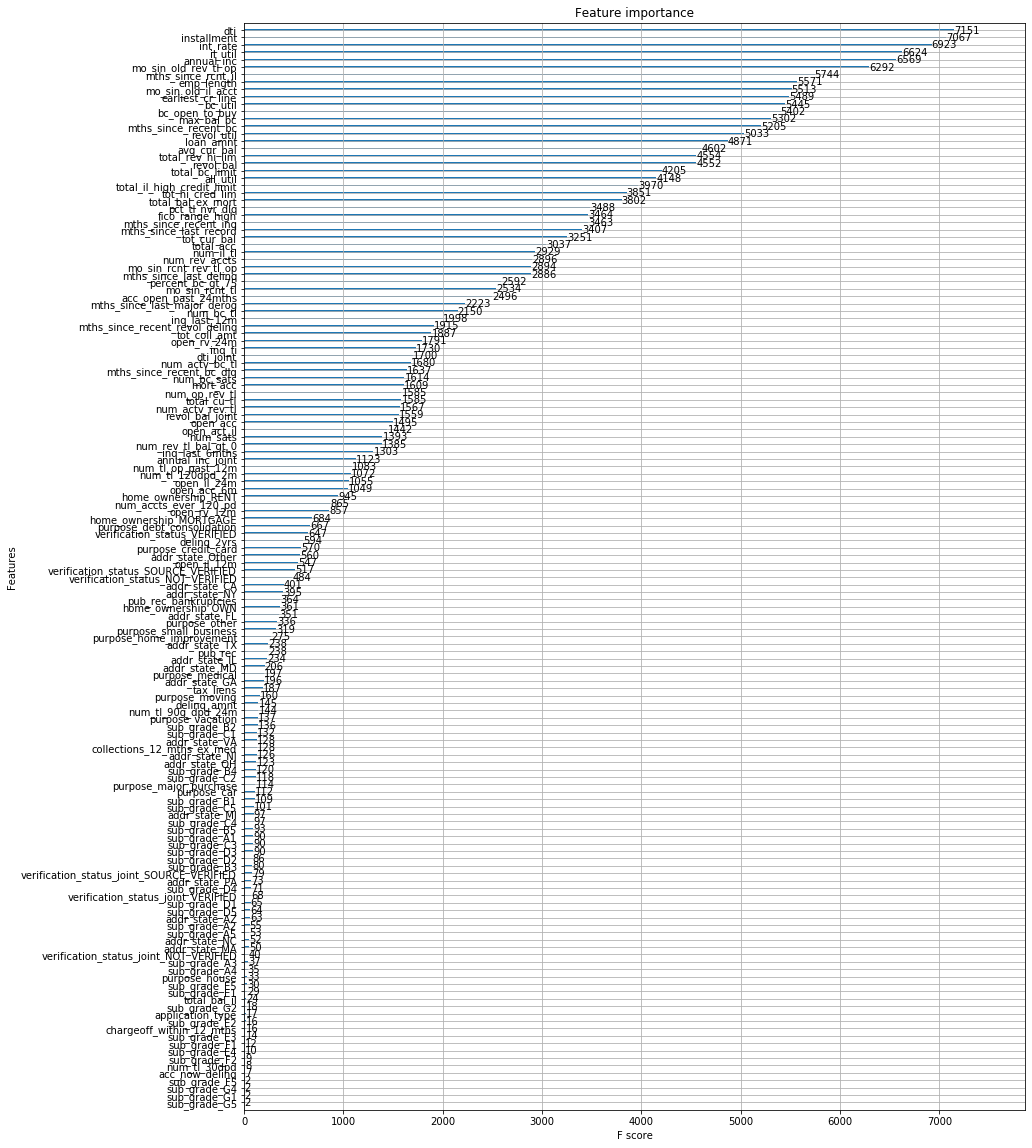

In [71]:
fig, ax = plt.subplots(1,1,figsize=(14, 20))
plot_importance(new_model.model, ax=ax)

In [23]:
# get listed loan
loans = DataHelper.get_listed_loandata()
loans.shape

(21, 99)

In [10]:
# prediction
loans, pred = new_model.predict_model(loans)

In [11]:
loans.shape

(21, 150)

In [13]:
pred

array([0.40066677, 0.10054713, 0.3782737 , 0.07344303, 0.13231926,
       0.08001054, 0.17792036, 0.06835487, 0.04401718, 0.12415784,
       0.05131809, 0.06228328, 0.10085095, 0.06531201, 0.06944966,
       0.12681447, 0.3507349 , 0.21464922, 0.10774083, 0.17643397,
       0.32030258], dtype=float32)